In [176]:
import os
import math
import pandas as pd
import numpy as np
import random
import dateutil.parser
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model

In [23]:
csv_files = ['./data/'+file for file in os.listdir('./data/') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file) for file in csv_files])
df_imported = df_imported.rename(columns={'Unnamed: 0': 'record_time'})
df_imported = df_imported.drop_duplicates(subset='record_time', keep='last')
df_imported = df_imported.set_index('record_time')
print(df_imported.columns)
df_imported

Index(['$', 'dateStamp', 'dew_point', 'modelCode', 'modelRun',
       'periodSchedule', 'pressure', 'screen_relative_humidity',
       'sea_temperature', 'surf_max', 'surf_min', 'swell_direction1',
       'swell_direction2', 'swell_direction3', 'swell_height1',
       'swell_height2', 'swell_height3', 'swell_period1', 'swell_period2',
       'swell_period3', 'temperature', 'wave_height', 'wave_period',
       'wind_direction', 'wind_speed'],
      dtype='object')


,$,dateStamp,dew_point,modelCode,modelRun,periodSchedule,pressure,screen_relative_humidity,sea_temperature,surf_max,...,swell_height2,swell_height3,swell_period1,swell_period2,swell_period3,temperature,wave_height,wave_period,wind_direction,wind_speed
record_time,,,,,,,,,,,,,,,,,,,,,
2016-05-14T16:00:00+00:00,960,NaN,10.7,NaN,NaN,NaN,1023,92.3,12.7,NaN,...,NaN,NaN,NaN,NaN,NaN,11.9,1.1,6,NW,4
2016-05-14T17:00:00+00:00,1020,NaN,10.8,NaN,NaN,NaN,1023,91.6,12.7,NaN,...,NaN,NaN,NaN,NaN,NaN,12.1,1.2,6,NNW,6
2016-05-14T18:00:00+00:00,1080,NaN,10.6,NaN,NaN,NaN,1023,91.7,12.9,NaN,...,NaN,NaN,NaN,NaN,NaN,11.9,1.0,5,NW,5
2016-05-14T19:00:00+00:00,1140,NaN,10.5,NaN,NaN,NaN,1024,91.6,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.8,1.1,5,NW,7
2016-05-14T20:00:00+00:00,1200,NaN,10.3,NaN,NaN,NaN,1024,92.3,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.5,1.1,6,WNW,7
2016-05-14T21:00:00+00:00,1260,NaN,10.3,NaN,NaN,NaN,1024,92.3,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.5,1.0,6,N,6
2016-05-14T22:00:00+00:00,1320,NaN,10.1,NaN,NaN,NaN,1024,91.6,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.4,1.1,6,WNW,6
2016-05-14T23:00:00+00:00,1380,NaN,9.9,NaN,NaN,NaN,1025,91.0,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.3,1.2,6,NW,7
2016-05-15T00:00:00+00:00,0,NaN,10.1,NaN,NaN,NaN,1025,91.0,12.8,NaN,...,NaN,NaN,NaN,NaN,NaN,11.5,1.1,6,WNW,2


In [24]:
target_var = 'surf_avg'
s_target = pd.Series( (df_imported['surf_max'] + df_imported['surf_min']) / 2, name=target_var )
print('available target values:', s_target.count())
# fill NAs with linearly interpolated data
# TODO: Only for points which are max. 5h apart
s_target = s_target.interpolate()
print('target values after interpolation:', s_target.count())
s_target

available target values: 9
target values after interpolation: 65


record_time
2016-05-14T16:00:00+00:00         NaN
2016-05-14T17:00:00+00:00         NaN
2016-05-14T18:00:00+00:00         NaN
2016-05-14T19:00:00+00:00         NaN
2016-05-14T20:00:00+00:00         NaN
2016-05-14T21:00:00+00:00         NaN
2016-05-14T22:00:00+00:00         NaN
2016-05-14T23:00:00+00:00         NaN
2016-05-15T00:00:00+00:00         NaN
2016-05-15T01:00:00+00:00    1.000000
2016-05-15T02:00:00+00:00    0.955000
2016-05-15T03:00:00+00:00    0.910000
2016-05-15T04:00:00+00:00    0.865000
2016-05-15T05:00:00+00:00    0.820000
2016-05-15T06:00:00+00:00    0.775000
2016-05-15T07:00:00+00:00    0.730000
2016-05-15T08:00:00+00:00    0.710000
2016-05-15T09:00:00+00:00    0.690000
2016-05-15T10:00:00+00:00    0.670000
2016-05-15T11:00:00+00:00    0.650000
2016-05-15T12:00:00+00:00    0.630000
2016-05-15T13:00:00+00:00    0.610000
2016-05-15T14:00:00+00:00    0.598182
2016-05-15T15:00:00+00:00    0.586364
2016-05-15T16:00:00+00:00    0.574545
2016-05-15T18:00:00+00:00    0.562727


In [25]:
df_explanatory = df_imported[['wind_direction','dew_point', 'screen_relative_humidity', 'pressure', 'wind_speed', 'sea_temperature', 'temperature', 'wave_height', 'wave_period']]
df_explanatory = df_explanatory.dropna()
df_explanatory
print(df_explanatory['wind_direction'].head())
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
df_explanatory['wind_direction'] = df_explanatory['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
print('\nbecomes',df_explanatory['wind_direction'].head())

record_time
2016-05-14T16:00:00+00:00     NW
2016-05-14T17:00:00+00:00    NNW
2016-05-14T18:00:00+00:00     NW
2016-05-14T19:00:00+00:00     NW
2016-05-14T20:00:00+00:00    WNW
Name: wind_direction, dtype: object

becomes record_time
2016-05-14T16:00:00+00:00    315.0
2016-05-14T17:00:00+00:00    337.5
2016-05-14T18:00:00+00:00    315.0
2016-05-14T19:00:00+00:00    315.0
2016-05-14T20:00:00+00:00    292.5
Name: wind_direction, dtype: float64


In [26]:
print('Data types of columns')
pd.DataFrame(df_explanatory.columns,[str(df_explanatory[column].dtype) for column in df_explanatory.columns])

Data types of columns


,0
float64,wind_direction
float64,dew_point
float64,screen_relative_humidity
int64,pressure
int64,wind_speed
float64,sea_temperature
float64,temperature
float64,wave_height
float64,wave_period


In [27]:
df_train = pd.merge(df_explanatory, pd.DataFrame(s_target), left_index=True, right_index=True).dropna()
df_train.count()

wind_direction              65
dew_point                   65
screen_relative_humidity    65
pressure                    65
wind_speed                  65
sea_temperature             65
temperature                 65
wave_height                 65
wave_period                 65
surf_avg                    65
dtype: int64

                              live
wind_direction            0.471228
dew_point                -0.693800
screen_relative_humidity -0.861516
pressure                 -0.972663
wind_speed                0.908444
sea_temperature           0.319246
temperature              -0.027676
wave_height               0.924409
wave_period               0.060069


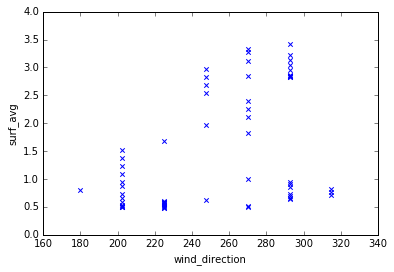

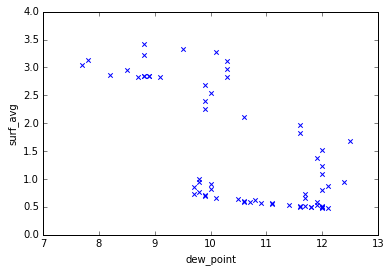

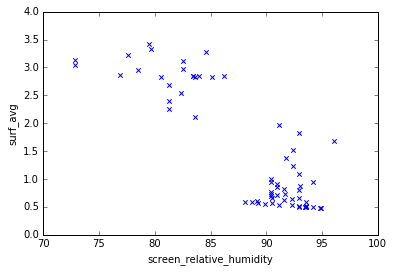

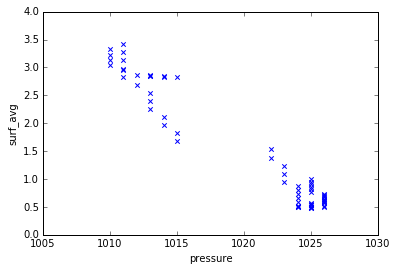

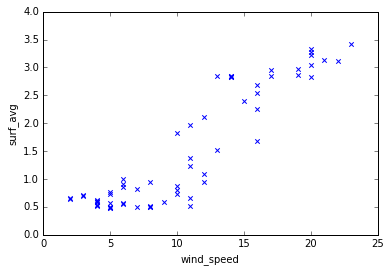

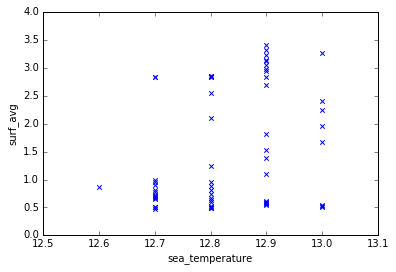

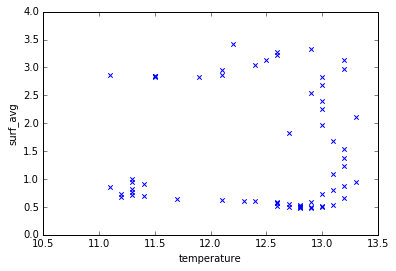

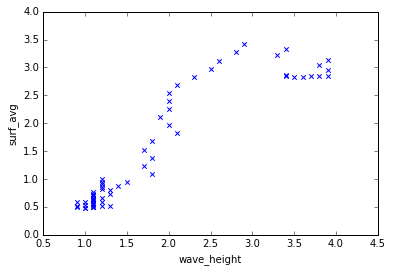

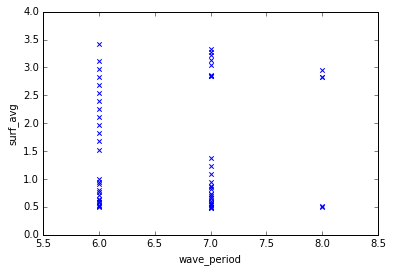

In [53]:
target_correlations = pd.Series([df_train[column].corr(df_train[target_var]) for column in df_explanatory.columns])
target_correlations.name = 'live'
target_correlations = pd.DataFrame(target_correlations)
target_correlations.index = df_explanatory.columns
print(target_correlations)
#fix, axes =plt.subplots(nrows=len(df_explanatory.columns), figsize=(8,8))
for column in df_explanatory.columns:
    df_train.plot.scatter(x=column, y=target_var, marker='x')

In [60]:
#df_ewma3 = pd.ewma(df_explanatory, span=3)
for span in range(3,12):
    target_correlations['ewma'+str(span)] = pd.Series([ pd.ewma(df_train[column], span=span).corr(df_train[target_var]) for column in df_explanatory.columns], index=df_explanatory.columns)
target_correlations
#column = 'pressure'
#pd.ewma(df_train[column], span=3).corr(df_train[target_var])

,live,ewma3,ewma4,ewma5,ewma6,ewma7,ewma8,ewma9,ewma10,ewma11,ewma12
wind_direction,0.471228,0.438602,0.413070,0.384543,0.353889,0.321826,0.288951,0.255756,0.222636,0.189907,0.157818
dew_point,-0.693800,-0.653920,-0.630013,-0.604659,-0.578269,-0.551213,-0.523792,-0.496245,-0.468762,-0.441489,-0.414546
screen_relative_humidity,-0.861516,-0.881659,-0.883311,-0.881794,-0.878031,-0.872786,-0.866632,-0.859976,-0.853095,-0.846176,-0.839343
pressure,-0.972663,-0.982939,-0.985360,-0.986558,-0.986765,-0.986202,-0.985062,-0.983507,-0.981667,-0.979644,-0.977516
wind_speed,0.908444,0.938769,0.946795,0.952994,0.957779,0.961431,0.964168,0.966170,0.967579,0.968513,0.969066
sea_temperature,0.319246,0.422900,0.460629,0.494167,0.523902,0.550016,0.572738,0.592367,0.609241,0.623706,0.636089
temperature,-0.027676,0.055209,0.096695,0.137270,0.176369,0.213636,0.248858,0.281925,0.312797,0.341485,0.368042
wave_height,0.924409,0.915479,0.910873,0.906778,0.903133,0.899849,0.896845,0.894062,0.891462,0.889019,0.886718
wave_period,0.060069,0.017082,-0.005121,-0.025260,-0.042918,-0.057905,-0.070189,-0.079847,-0.087035,-0.091956,-0.094843


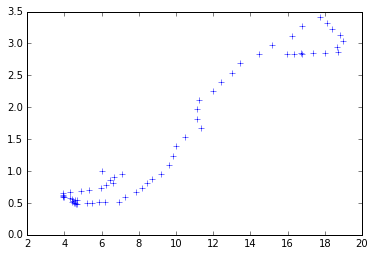

In [64]:
plt.plot(pd.ewma(df_train['wind_speed'], span=12), df_train[target_var], 'b+')

In [191]:
# randomly sample a train and test set
def split_dataset(df_in, percent_test):
    total_size = len(df_in)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ df_train.index[randint] for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.DataFrame(df_train.loc[record_labels])
    df_train = df_train.drop(record_labels)
    return df_train, df_test

coefficients:  [  3.11305669e-03   3.40418719e+00  -6.07678568e-01  -7.04548510e-02
   5.12534632e-02  -2.84101114e-02  -3.38201700e+00   2.40626219e-01
  -2.42033512e-02]


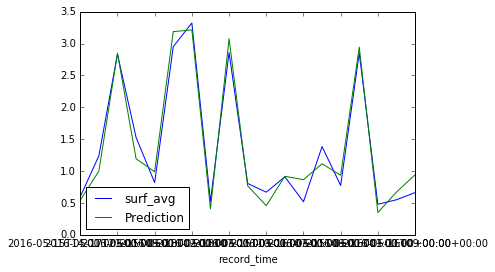

In [204]:
# perform predictionon unaveraged data
regr = linear_model.LinearRegression()
train_set, test_set = split_dataset(df_train, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
print('coefficients: ', coefficients)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
compare = pd.concat([test_set[target_var], predictions], axis=1)
compare.plot()

coefficients:  [  4.54788102e-03   9.26996585e+00  -1.54602533e+00  -1.18351500e-01
   8.32561518e-02  -3.86585465e-01  -8.89266420e+00   2.51086941e-01
  -4.14764615e-01]


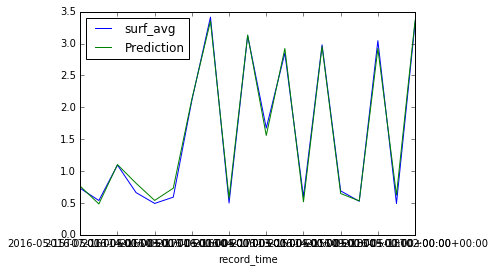

In [209]:
# perform prediction on ewma with span 12
regr = linear_model.LinearRegression()
df_ewma12 = pd.concat([pd.ewma(df_train[df_explanatory.columns], span=12), df_train[target_var]], axis=1)
train_set, test_set = split_dataset(df_ewma12, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
print('coefficients: ', coefficients)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
compare = pd.concat([test_set[target_var], predictions], axis=1)
compare.plot()